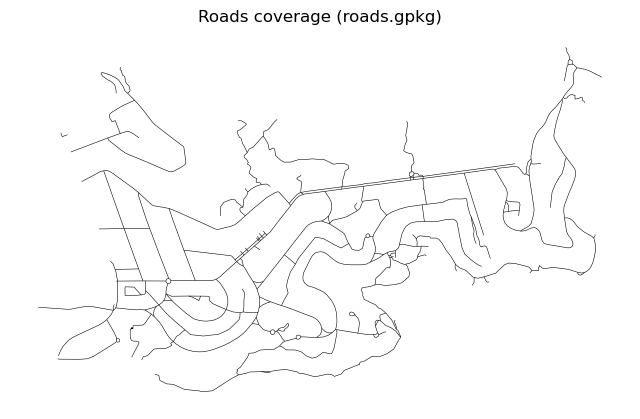

In [109]:
# Preview roads coverage
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import fiona
import pandas as pd

roads_path = Path('data/roads.gpkg')
# Load all layers if present
layers = []
try:
    layers = list(fiona.listlayers(roads_path))
except Exception:
    layers = []

frames = []
if layers:
    for layer in layers:
        try:
            g = gpd.read_file(roads_path, layer=layer)
            if not g.empty:
                frames.append(g)
        except Exception:
            pass
else:
    frames = [gpd.read_file(roads_path)]

roads = pd.concat(frames, ignore_index=True) if frames else gpd.GeoDataFrame(columns=['geometry'])
roads = gpd.GeoDataFrame(roads, geometry='geometry')
roads = roads[roads.geometry.notna()]

fig, ax = plt.subplots(figsize=(8, 8))
roads.plot(ax=ax, linewidth=0.4, color='black')
ax.set_title('Roads coverage (roads.gpkg)')
ax.set_axis_off()
plt.show()



In [110]:
# Configuration
from pathlib import Path

# Sample size 
SAMPLE_SIZE = 500 # None to process all

ROOT = Path('.')
GNAF_PARQUET = ROOT / 'data' / 'gnaf_prop.parquet'
ROADS_GPKG = ROOT / 'data' / 'roads.gpkg'
OUTPUT_CSV = ROOT / 'output' / 'property_orientation.csv'

# Columns to retain if present
KEEP_COLS = [
    'address', 'state', 'postcode', 'locality_name', 'street_name', 'lot_number',
    'lat', 'lon', 'orientation_degrees', 'orientation_cardinal'
]

In [111]:
import pandas as pd
pd.read_parquet(GNAF_PARQUET).head()



,gid,gnaf_pid,street_locality_pid,locality_pid,alias_principal,primary_secondary,building_name,lot_number,flat_number,level_number,...,confidence,legal_parcel_id,mb_2016_code,mb_2021_code,latitude,longitude,geocode_type,reliability,geom,schema
0,3115,GANSW705858629,NSW2878308,locc9618e9a6979,P,None,None,1,None,None,...,2,1/105203,10840311000,10840311000,-33.787478,151.182595,PROPERTY CENTROID,2,0101000020BB100000E599B8D1D7E562406816D312CCE4...,gnaf_202402
1,3120,GANSW705858630,NSW2878308,locc9618e9a6979,P,None,None,26,None,None,...,2,26/7045,10840312000,10840312000,-33.787164,151.183209,PROPERTY CENTROID,2,0101000020BB1000008215D0D9DCE562403E3335C7C1E4...,gnaf_202402
2,3123,GANSW705858631,NSW2878308,locc9618e9a6979,P,None,None,16,None,None,...,2,15/455712,10840311000,10840311000,-33.787375,151.182549,PROPERTY CENTROID,2,0101000020BB100000E8F3B470D7E562406A31BAB4C8E4...,gnaf_202402
3,3126,GANSW705858632,NSW2878308,locc9618e9a6979,P,None,None,27,None,None,...,2,27/7045,10840312000,10840312000,-33.787023,151.183146,PROPERTY CENTROID,2,0101000020BB1000009DEE2354DCE56240D5DAEA28BDE4...,gnaf_202402
4,3130,GANSW705858633,NSW2878308,locc9618e9a6979,P,None,None,1,None,None,...,2,1/963791,10840311000,10840311000,-33.787273,151.182502,PROPERTY CENTROID,2,0101000020BB1000005048190ED7E5624024456458C5E4...,gnaf_202402


In [112]:
import math
from typing import Optional, Tuple, List

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import shapely
from shapely.strtree import STRtree


def normalize_bearing_degrees(degrees: float) -> float:
    value = degrees % 360.0
    if value < 0:
        value += 360.0
    return value


def segment_bearing_degrees(a_lon: float, a_lat: float, b_lon: float, b_lat: float) -> float:
    # Bearing from point A to B (0° = North, clockwise)
    d_lon = math.radians(b_lon - a_lon)
    lat1 = math.radians(a_lat)
    lat2 = math.radians(b_lat)
    x = math.sin(d_lon) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_lon)
    bearing = math.degrees(math.atan2(x, y))
    return normalize_bearing_degrees(bearing)


def bearing_to_cardinal_8(degrees: float) -> str:
    dirs = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]
    idx = int((degrees + 22.5) // 45) % 8
    return dirs[idx]


def explode_to_lines(geom: shapely.Geometry) -> List[LineString]:
    if geom is None:
        return []
    if isinstance(geom, LineString):
        return [geom]
    if geom.geom_type == "MultiLineString":
        return [ls for ls in geom.geoms if isinstance(ls, LineString)]
    return []


def _bounds_in_melbourne(b: Tuple[float, float, float, float]) -> bool:
    minx, miny, maxx, maxy = b  # lon_min, lat_min, lon_max, lat_max
    return (miny >= -38.8 and maxy <= -37.0 and minx >= 144.0 and maxx <= 146.2)


def _infer_to_wgs84(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    if gdf.crs:
        return gdf if gdf.crs.to_epsg() == 4326 else gdf.to_crs(4326)
    # Default to WGS84 if CRS is missing
    return gdf.set_crs(4326, allow_override=True)


def load_local_roads(roads_path: Path) -> Tuple[List[LineString], Optional[STRtree]]:
    if not roads_path.exists():
        raise FileNotFoundError(f"Roads gpkg not found: {roads_path}")
    roads_gdf = gpd.read_file(roads_path)
    if roads_gdf.empty:
        raise RuntimeError("Roads gpkg is empty")
    roads_gdf = _infer_to_wgs84(roads_gdf)
    line_geoms: List[LineString] = []
    for geom in roads_gdf.geometry:
        line_geoms.extend(explode_to_lines(geom))
    if not line_geoms:
        raise RuntimeError("No LineString geometries found in roads")
    tree = STRtree(line_geoms)
    return line_geoms, tree


def nearest_line_with_strtree(point: Point, lines: List[LineString], tree: Optional[STRtree]) -> Optional[LineString]:
    if tree is not None:
        best = tree.nearest(point)
        if isinstance(best, LineString):
            return best
    return min(lines, key=lambda g: point.distance(g))


def compute_orientation_from_local_roads(lat: float, lon: float, lines: List[LineString], tree: Optional[STRtree]) -> Tuple[Optional[float], Optional[str]]:
    pt = Point(lon, lat)
    line = nearest_line_with_strtree(pt, lines, tree)
    if line is None:
        return None, None
    proj_dist = line.project(pt)
    nearest_on_road = line.interpolate(proj_dist)
    facing = segment_bearing_degrees(nearest_on_road.x, nearest_on_road.y, pt.x, pt.y)
    cardinal = bearing_to_cardinal_8(facing)
    return facing, cardinal


def get_roads_bounds(roads_path: Path) -> Tuple[float, float, float, float]:
    gdf = gpd.read_file(roads_path)
    gdf = _infer_to_wgs84(gdf)
    minx, miny, maxx, maxy = gdf.total_bounds
    return float(minx), float(miny), float(maxx), float(maxy)


def filter_bbox(df: pd.DataFrame, lat_col: str, lon_col: str, bounds: Tuple[float, float, float, float]) -> pd.DataFrame:
    minx, miny, maxx, maxy = bounds
    mask = (
        df[lat_col].astype(float).between(miny, maxy)
        & df[lon_col].astype(float).between(minx, maxx)
    )
    return df.loc[mask].copy()


In [113]:
# Load roads
lines, tree = load_local_roads(ROADS_GPKG)
ROADS_BOUNDS = get_roads_bounds(ROADS_GPKG)
ROADS_BOUNDS


(151.2084668, -33.806042, 151.230767, -33.794718)

In [114]:
# Helper to detect lat/lon columns

def find_lat_lon_columns(df: pd.DataFrame) -> Tuple[str, str]:
    cols = {c.lower(): c for c in df.columns}
    lat_candidates = ['lat', 'latitude', 'y']
    lon_candidates = ['lon', 'longitude', 'x']
    lat_col = next((cols[c] for c in lat_candidates if c in cols), None)
    lon_col = next((cols[c] for c in lon_candidates if c in cols), None)
    if not lat_col or not lon_col:
        raise ValueError(f"Could not detect lat/lon columns. Columns present: {list(df.columns)}")
    return lat_col, lon_col



In [115]:
# Load source points (GNAF properties)
df = pd.read_parquet(GNAF_PARQUET)

lat_col, lon_col = find_lat_lon_columns(df)

# Drop NaNs and filter to roads coverage bbox
pts = df.dropna(subset=[lat_col, lon_col]).copy()
pts = filter_bbox(pts, lat_col, lon_col, ROADS_BOUNDS)
if SAMPLE_SIZE:
    pts = pts.head(SAMPLE_SIZE).copy()

print('gnaf', len(pts))
pts.head(3)


gnaf 500


,gid,gnaf_pid,street_locality_pid,locality_pid,alias_principal,primary_secondary,building_name,lot_number,flat_number,level_number,...,confidence,legal_parcel_id,mb_2016_code,mb_2021_code,latitude,longitude,geocode_type,reliability,geom,schema
141,37709,GANSW704341135,NSW2828125,loc921cf8679ff0,P,None,None,146,None,None,...,2,146/13097,11204671200,11204671200,-33.801559,151.214647,PROPERTY CENTROID,2,0101000020BB1000002D113D63DEE662400B5D0D7999E6...,gnaf_202402
142,37710,GANSW704341147,NSW2914074,loc921cf8679ff0,P,None,None,49,None,None,...,2,49/11138,10843171000,10843171000,-33.803980,151.215625,PROPERTY CENTROID,2,0101000020BB100000EEFD5767E6E662403B6089CDE8E6...,gnaf_202402
143,37711,GANSW704341149,NSW2914074,loc921cf8679ff0,P,None,None,48,None,None,...,2,48/11138,10843171000,10843171000,-33.803980,151.215445,PROPERTY CENTROID,2,0101000020BB1000003BCC34EDE4E6624095390ACEE8E6...,gnaf_202402


In [116]:
# Compute orientations
results = []
for i, row in pts.iterrows():
    lat = float(row[lat_col])
    lon = float(row[lon_col])
    deg, card = compute_orientation_from_local_roads(lat, lon, lines, tree)
    base = {
        'lat': lat,
        'lon': lon,
        'orientation_degrees': deg,
        'orientation_cardinal': card,
    }
    carry = {k: row[k] for k in KEEP_COLS if k in row.index}
    results.append({**carry, **base})

out = pd.DataFrame(results)
out.head()


,address,state,postcode,locality_name,street_name,lot_number,lat,lon,orientation_degrees,orientation_cardinal
0,7 CHARLES STREET,NSW,2068,CASTLECRAG,CHARLES,146,-33.801559,151.214647,184.680729,S
1,22 THE PARAPET,NSW,2068,CASTLECRAG,THE PARAPET,49,-33.803980,151.215625,342.411798,N
2,24 THE PARAPET,NSW,2068,CASTLECRAG,THE PARAPET,48,-33.803980,151.215445,358.277314,N
3,27 THE PARAPET,NSW,2068,CASTLECRAG,THE PARAPET,33,-33.803174,151.214389,30.565428,NE
4,109 EASTERN VALLEY WAY,NSW,2068,CASTLECRAG,EASTERN VALLEY,10,-33.801401,151.211510,23.992643,NE


In [117]:
OUTPUT_CSV.parent.mkdir(parents=True, exist_ok=True)
out.to_csv(OUTPUT_CSV, index=False)

print(out['orientation_cardinal'].value_counts(dropna=False).sort_index())


orientation_cardinal
E      15
N     152
NE     79
NW     39
S     108
SE     24
SW     59
W      24
Name: count, dtype: int64


In [118]:
# North-facing and summary stats for solar insights
# Uses `out` DataFrame produced above

# Overall north-facing
north_mask = out['orientation_cardinal'] == 'N'
summary_overall = {
    'total_properties': int(len(out)),
    'north_facing_count': int(north_mask.sum()),
    'north_facing_pct': float((north_mask.mean() * 100).round(2)),
}
print('Overall:', summary_overall)

# Orientation distribution
print('\nOrientation distribution:')
print(out['orientation_cardinal'].value_counts(dropna=False).sort_index())

# By locality
if 'locality_name' in out.columns:
    by_loc = out.groupby('locality_name').agg(
        total=('orientation_cardinal', 'size'),
        north=('orientation_cardinal', lambda s: (s == 'N').sum()),
    )
    by_loc['north_pct'] = (by_loc['north'] / by_loc['total'] * 100).round(2)
    top_loc = by_loc[by_loc['total'] >= 20].sort_values('north_pct', ascending=False).head(20)
    print('\nTop localities by north-facing % (min 20 props):')
    display(top_loc)

# By postcode
if 'postcode' in out.columns:
    by_pc = out.groupby('postcode').agg(
        total=('orientation_cardinal', 'size'),
        north=('orientation_cardinal', lambda s: (s == 'N').sum()),
    )
    by_pc['north_pct'] = (by_pc['north'] / by_pc['total'] * 100).round(2)
    top_pc = by_pc[by_pc['total'] >= 50].sort_values('north_pct', ascending=False).head(20)
    print('\nTop postcodes by north-facing % (min 50 props):')
    display(top_pc)



Overall: {'total_properties': 500, 'north_facing_count': 152, 'north_facing_pct': 30.4}

Orientation distribution:
orientation_cardinal
E      15
N     152
NE     79
NW     39
S     108
SE     24
SW     59
W      24
Name: count, dtype: int64

Top localities by north-facing % (min 20 props):


,total,north,north_pct
locality_name,,,
WILLOUGHBY,72,36,50.00
MIDDLE COVE,30,13,43.33
CASTLECRAG,365,102,27.95
WILLOUGHBY EAST,25,1,4.00



Top postcodes by north-facing % (min 50 props):


,total,north,north_pct
postcode,,,
2068,492,152,30.89


Saved investor map to: output/investor_orientation_map.png


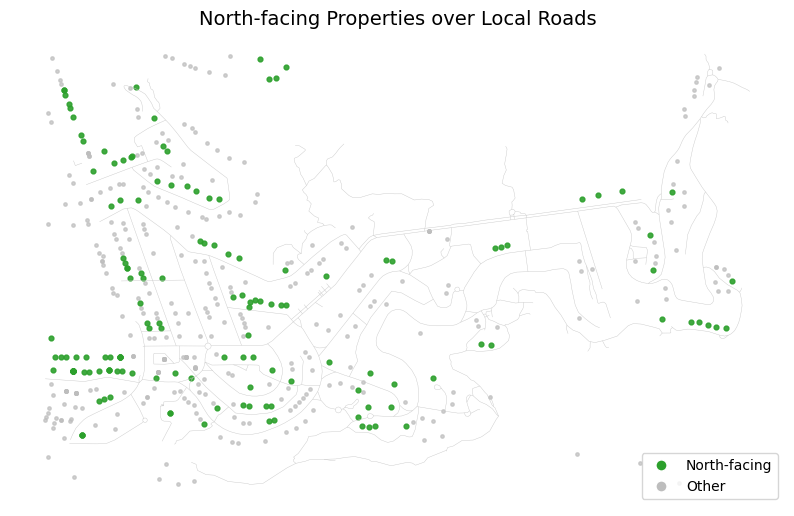

In [119]:
# Investor-ready map: highlight north-facing properties over roads
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Build points GeoDataFrame from `out`
gdf_out = gpd.GeoDataFrame(
    out.copy(),
    geometry=gpd.points_from_xy(out['lon'], out['lat']),
    crs='EPSG:4326'
)

# Load roads from gpkg (single combined layer)
try:
    roads_plot = gpd.read_file(ROADS_GPKG)
    roads_plot = roads_plot[roads_plot.geometry.notna()]
    roads_plot = roads_plot.to_crs('EPSG:4326')
except Exception:
    roads_plot = None

north_mask = gdf_out['orientation_cardinal'] == 'N'
pts_n = gdf_out[north_mask]
pts_other = gdf_out[~north_mask]

fig, ax = plt.subplots(figsize=(10, 10))
if roads_plot is not None and not roads_plot.empty:
    roads_plot.plot(ax=ax, linewidth=0.3, color='#c7c7c7')

# Plot others first (light gray), then north (green)
if not pts_other.empty:
    pts_other.plot(ax=ax, markersize=6, color='#bdbdbd', alpha=0.7)
if not pts_n.empty:
    pts_n.plot(ax=ax, markersize=12, color='#2ca02c', alpha=0.9)

ax.set_title('North-facing Properties over Local Roads', fontsize=14)
ax.set_axis_off()

# Legend
legend_elems = [
    Line2D([0], [0], marker='o', color='w', label='North-facing', markerfacecolor='#2ca02c', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Other', markerfacecolor='#bdbdbd', markersize=8),
]
ax.legend(handles=legend_elems, loc='lower right')

# Save
OUTPUT_CSV.parent.mkdir(parents=True, exist_ok=True)
img_path = OUTPUT_CSV.parent / 'investor_orientation_map.png'
plt.savefig(img_path, dpi=200, bbox_inches='tight', facecolor='white')
print(f'Saved investor map to: {img_path}')

